<p align="left">
  <img src="./logo_UTN.svg" />
</p>


# **Teoría de Circuitos II - R4001 - 2023**
## Trabajo Semanal 8
### Autor: Bruno Glecer



# Parte 1

## Diseño IIR

### Inicialización y parametros del filtro

In [120]:
import warnings
warnings.filterwarnings('ignore')
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

#Parametros del filtro
fs = 1000
fny = fs / 2

ripple = 0 # dB
atenuacion = 40 # dB

fs1 = 1.0 #Hz
fp1 = 3.0 #Hz
fp2 = 25.0 #Hz
fs2 = 35.0 #Hz

# Frecuencias digitales y ganancias para dibujar plantilla
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         fny   ]) / fny 
gains_db = 10**(np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])/20)


### Diseño filtro IIR

In [69]:
iir_sos = sig.iirdesign([fp1, fp2], [fs1, fs2], ripple+0.5, atenuacion, ftype='butter', fs=fs, output='sos', analog=False)

iir_W, iir_H = sig.sosfreqz(iir_sos, fs=fs, worN=10000)

### Diseño filtro FIR

In [70]:
bands = [[0, ws1] , [ws1, wp1], [wp1, wp2], [wp2, ws2], [ws2, fs/2]]
gains_db = [[-atenuacion, -atenuacion], [-atenuacion, 0], [0, 0], [0, -atenuacion], [-atenuacion, -atenuacion]]
gains = 10**(np.array(gains_db)/20)

taps_ls = sig.firls(5001, bands, gains, fs=fs)

fir_W, fir_H = sig.freqz(taps_ls, [1], worN=10000, fs=fs)


### Respuestas de modulo

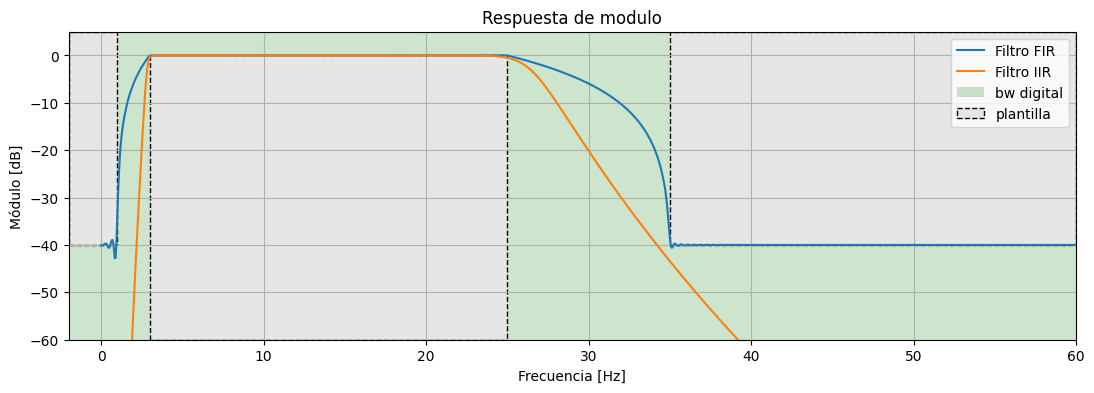

In [122]:
mpl.rcParams['figure.figsize'] = (13,4)

plt.plot(fir_W, 20*np.log10(np.abs(fir_H)), label="Filtro FIR")
plt.plot(iir_W, 20*np.log10(np.abs(iir_H)), label="Filtro IIR")

plt.title('Respuesta de modulo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([-2, 60, -60, 5 ]);
plot_plantilla(filter_type = 'bandpass', fpass=[fp1, fp2], fstop=[fs1, fs2], ripple=ripple, attenuation=atenuacion, fs = fs)



### Respuesta de fase FIR

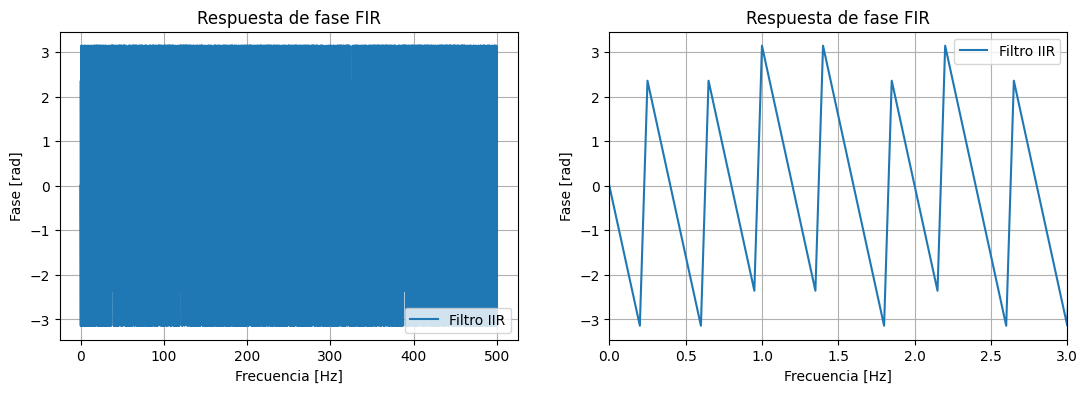

In [145]:
fig, ax = plt.subplots(1,2)

ax[0].plot(fir_W, np.angle(fir_H), label="Filtro IIR")
ax[0].set_title('Respuesta de fase FIR')
ax[0].set_xlabel('Frecuencia [Hz]')
ax[0].set_ylabel('Fase [rad]')
ax[0].grid()
ax[0].legend()

ax[1].plot(fir_W, np.angle(fir_H), label="Filtro IIR")
ax[1].set_title('Respuesta de fase FIR')
ax[1].set_xlabel('Frecuencia [Hz]')
ax[1].set_ylabel('Fase [rad]')
ax[1].set_xlim(0,3)
ax[1].grid()
ax[1].legend()

plt.show()

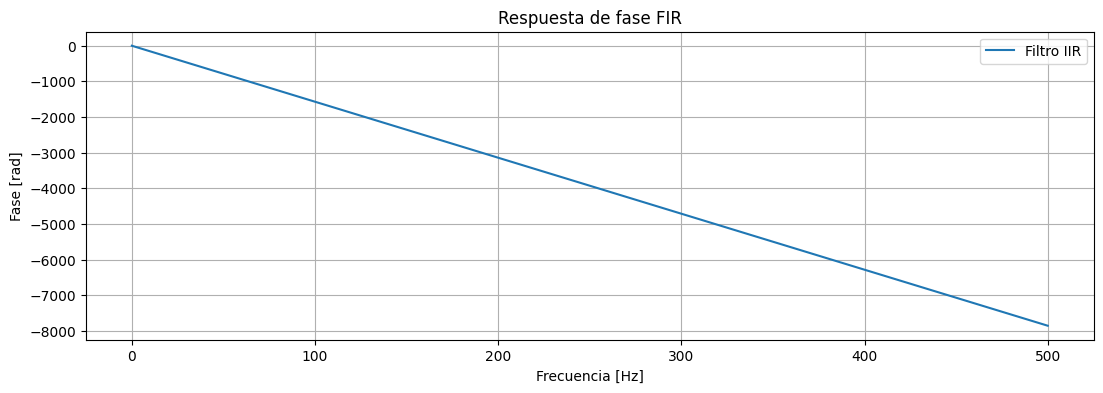

In [149]:
def angle_to_winding_number(angles):
    diff_angles = np.diff(angles)
    winding_changes = np.where(diff_angles > np.pi, -2*np.pi, 0) + np.where(diff_angles < -np.pi, 2*np.pi, 0)
    winding_numbers = np.append([0], np.cumsum(winding_changes))
    return winding_numbers + angles

fig, ax = plt.subplots()

ax.plot(fir_W, angle_to_winding_number(np.angle(fir_H)), label="Filtro IIR")
ax.set_title('Respuesta de fase FIR')
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Fase [rad]')
ax.grid()
ax.legend()


plt.show()

### Respuesta de IIR

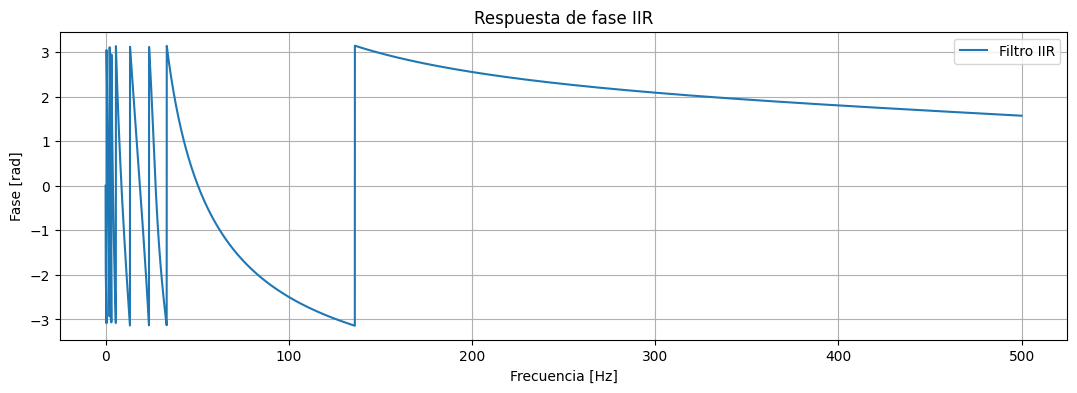

In [172]:
fig, ax = plt.subplots()

ax.plot(iir_W, (np.angle(iir_H)), label="Filtro IIR")
ax.set_title('Respuesta de fase IIR')
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Fase [rad]')
ax.grid()
ax.legend()

plt.show()

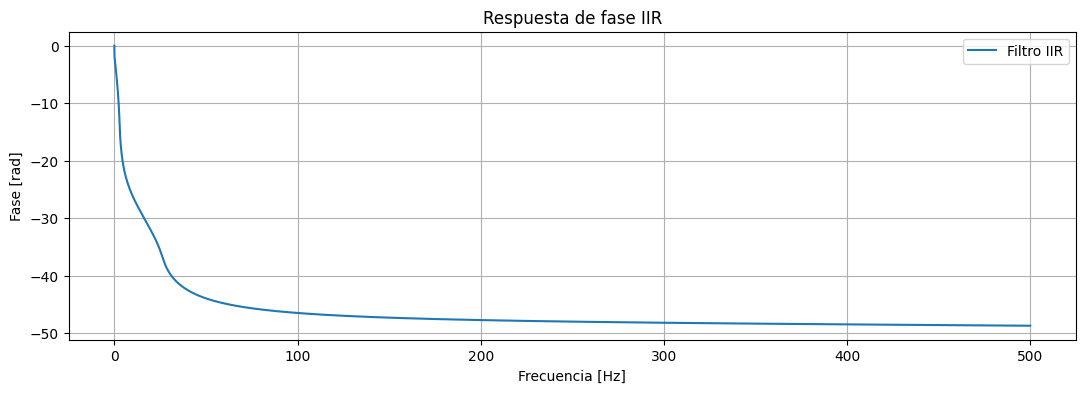

In [154]:
fig, ax = plt.subplots()

ax.plot(iir_W, angle_to_winding_number(np.angle(iir_H)), label="Filtro IIR")
ax.set_title('Respuesta de fase IIR')
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Fase [rad]')
ax.grid()
ax.legend()


plt.show()

### Respuesta de retardo de grupo

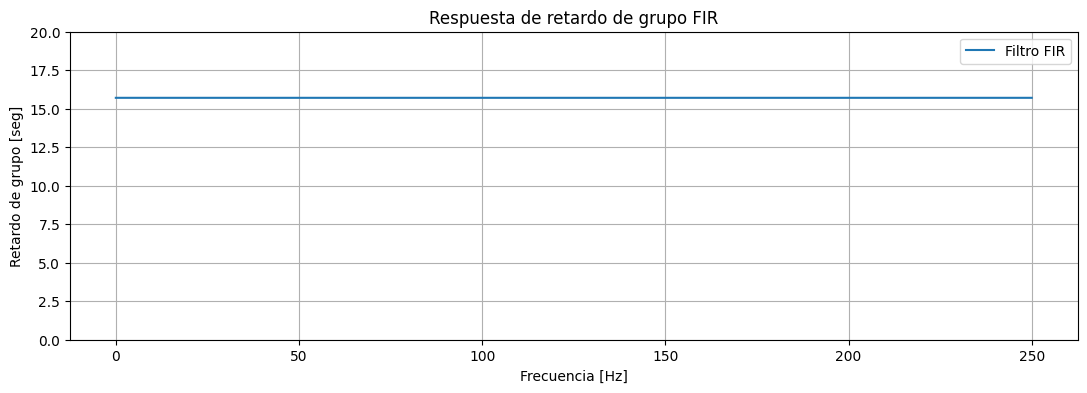

In [213]:
def get_delay_from_freq_response(W, H):
    new_freq = (W[1:] + W[:1])/2
    angles = angle_to_winding_number(np.angle(H))
    group_delay =  -np.diff(angles)/np.diff(W)
    return (new_freq, group_delay)

fig, ax = plt.subplots()

ax.plot(*get_delay_from_freq_response(fir_W, fir_H), label="Filtro FIR")
ax.set_title('Respuesta de retardo de grupo FIR')
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Retardo de grupo [seg]')
ax.grid()
ax.set_ylim(0,20)
ax.legend()


plt.show()

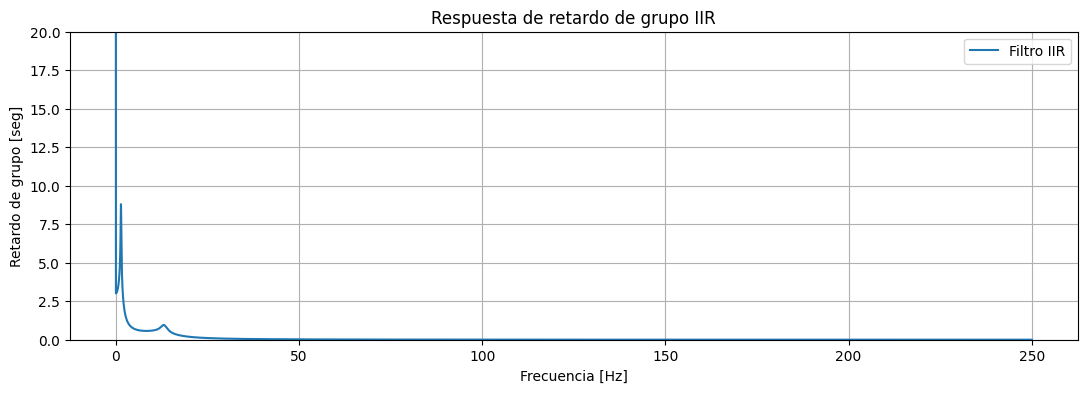

In [190]:
def get_delay_from_freq_response(W, H):
    new_freq = (W[1:] + W[:1])/2
    angles = angle_to_winding_number(np.angle(H))
    group_delay =  -np.diff(angles)/np.diff(W)
    return (new_freq, group_delay)

fig, ax = plt.subplots()

ax.plot(*get_delay_from_freq_response(iir_W, iir_H), label="Filtro IIR")
ax.set_title('Respuesta de retardo de grupo IIR')
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Retardo de grupo [seg]')
ax.grid()
ax.set_ylim(0,20)
ax.legend()


plt.show()

### Respuesta al impulso

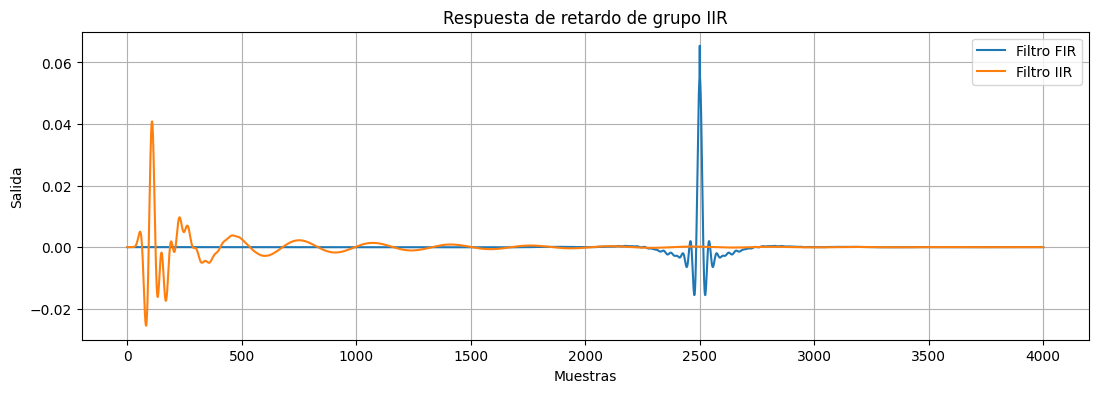

In [228]:
impulse = np.concatenate(([1], np.zeros(4000)))

fir_response = sig.lfilter(taps_ls, [1], impulse)
iir_response = sig.sosfilt(iir_sos, impulse)


fig, ax = plt.subplots()

ax.plot(fir_response, label="Filtro FIR")
ax.plot(iir_response, label="Filtro IIR")

ax.set_title('Respuesta de retardo de grupo IIR')
ax.set_xlabel('Muestras')
ax.set_ylabel('Salida')
ax.grid()
ax.legend()


plt.show()

# Parte 2

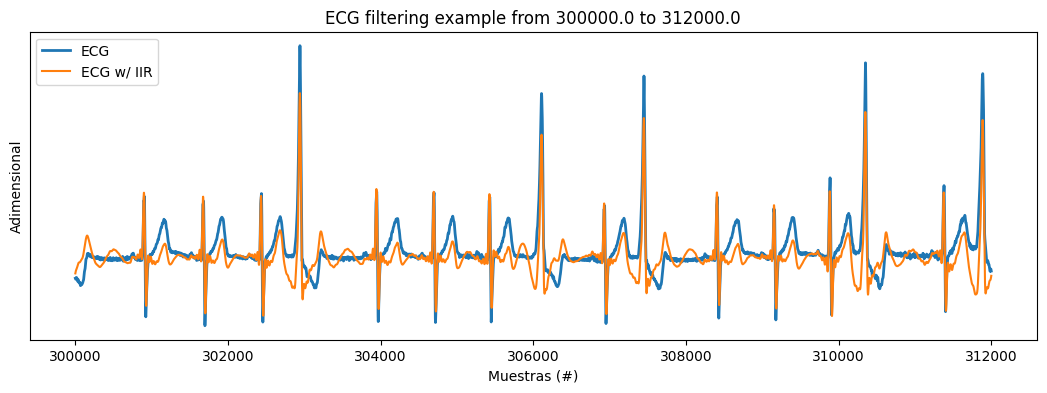

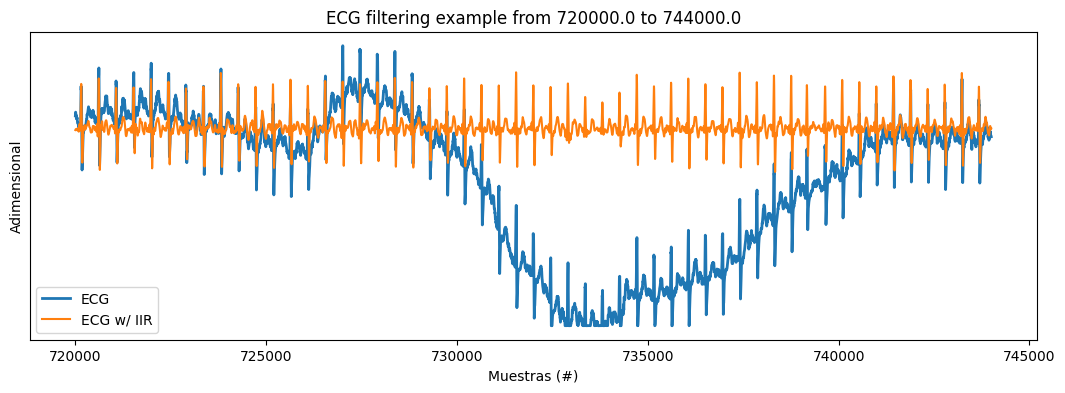

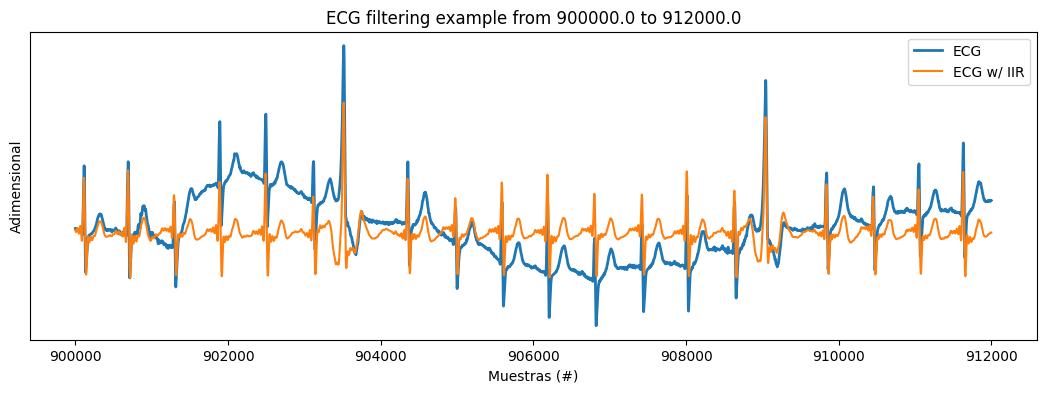

In [232]:
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

ecg_iir = sig.sosfiltfilt(iir_sos, ecg_one_lead)


regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ecg_iir[zoom_region], label='ECG w/ IIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()